In [1]:
# import statements
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
from astropy.io import fits
from scipy import ndimage
from photutils import centroid_sources, centroid_com, centroid_1dg, centroid_2dg
from astroCalibReduction import *

1. Gather Clio data
2. Outline of reduction script:
3. linearity correction
4. bad pixel correction
5. sky subtraction via nodding pairs
6. coarse registration, then fine registration via IDL

In [2]:
root = os.getcwd()
datadir = 'C:/Users/willi/Dropbox (Amherst College)/Research/Follette-Lab/Thesis-data/William/trapezium_data/'

In [3]:
badpixelpath = datadir + '../Clio2_reduction_files/badpix_fullframe.fit'
badpixelmap = fits.getdata(badpixelpath)

In [ ]:
## begin testing ##

In [9]:
intTime=300
# get data
datasets, darks = sortCliodata(datadir)
# get bad pixel map
badpixelmap = fits.getdata(badpixelpath)
# create master dark
med_dark = createMasterDark(darks, intTime)

In [ ]:
# loop through datasets and correct them
for dataset in datasets:
    runSubtraction(dataset, med_dark, intTime, badpixelmap)

In [4]:
# get new subtracted data
reduced_data, darks2 = sortCliodata(datadir, filesufx='*_LDBP*.fit*')

In [16]:
result = np.where(test == np.amax(test))
listOfCordinates = list(zip(result[0], result[1]))
print(listOfCordinates[0])

(181, 420)


putting files in an existing folder.
Max x-shift=0, max y-shift=3 (pixels)

 Done stacking!
Max x-shift=0, max y-shift=0 (pixels)

 Done stacking!


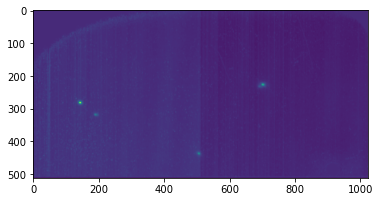

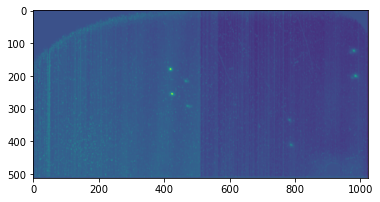

In [34]:
# run nodSubtraction
for dataset in [reduced_data[0]]:
    savepath = datadir+'/reduced/'
    try:
        os.makedirs(savepath)
    except OSError:
        print('putting files in an existing folder.')
    head = fits.getheader(dataset[0])
    band, name, datetime = head['PASSBAND'], head['CID'], head['DATE']
    date = datetime.split('T')[0]
    name = name.split(' * ')[-1]
    filename = name+'_'+band+'_'+date+'_nodsub.fits'
#     nodSubtraction(dataset, path=savepath+filename)
    path=savepath+filename
    imlist = dataset
    im1 = imlist[0]
    im1data = fits.getdata(im1)
    im1head = fits.getheader(im1)

    # create list of nods
    nod1 = []
    nod2 = []
    for im in imlist:
        hdr = fits.getheader(im)
        if hdr['BEAM'] == 0:
            nod1.append(im)
        elif hdr['BEAM'] == 1:
            nod2.append(im)
        else:
            print('there are more than two nods!')
    # prepare median nods for subtraction
    nod_A_cube = np.zeros((len(nod1), im1data.shape[0], im1data.shape[1]))
    nod_B_cube = np.zeros((len(nod2), im1data.shape[0], im1data.shape[1]))

    j = 0
    k = 0
    for i in range(len(imlist)):
        img = imlist[i]
        imdata = fits.getdata(img)
        if img in nod1:
            nod_A_cube[j] = imdata
            j += 1
        elif img in nod2:
            nod_B_cube[k] = imdata
            k += 1

    a_nod_med = crosscube(nod_A_cube, 250, 400, box=250, returnmed='y', returncube='n')
    b_nod_med = crosscube(nod_B_cube, 250, 400, box=250, returnmed='y', returncube='n')
    plt.figure()
    plt.imshow(a_nod_med)
    plt.figure()
    plt.imshow(b_nod_med)

    # perform nod subtraction on each image
    nodsubs = np.zeros((len(imlist), im1data.shape[0], im1data.shape[1]))
    j = 0
    k = 0
    for i in range(len(imlist)):
        img = imlist[i]
        if img in nod1:
            # subtract opposite nod median from single image
            imdata = nod_A_cube[j]
            bg_sub_imdata = b_nod_med - imdata  # imdata - b_nod_med
            nodsubs[i] = bg_sub_imdata
            j += 1
        elif img in nod2:
            imdata = nod_B_cube[k]
            bg_sub_imdata = a_nod_med - imdata  # imdata - a_nod_med
            nodsubs[i] = bg_sub_imdata
            k += 1

    # write the cube of unshifted nod subtracted images to disk
    fits.writeto(path, nodsubs, header=im1head, overwrite=True)

In [ ]:
## end testing ##

In [ ]:
runtheReduction(datadir, badpixelpath)

In [ ]:
result = fits.getdata()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(result[300:400, 120:220], origin='lower', cmap='inferno', norm=col.LogNorm(vmin=10, vmax=10000))
plt.colorbar()

In [ ]:
for im in test3:
    plt.figure()
    plt.imshow(im)

In [ ]:
data = test2[300:400, 120:220]
y_init = (80, 70, 25, 5)
x_init = (40, 80, 55, 54)
x, y = centroid_sources(data, x_init, y_init, box_size=15,
                        centroid_func=centroid_2dg)
plt.figure(figsize=(8, 4))
plt.imshow(data, origin='lower', interpolation='nearest', cmap='inferno', norm=col.LogNorm(vmin=10, vmax=10000))
plt.scatter(x, y, marker='+', s=80, c=[0,1,2,3])
plt.tight_layout()